# Case Study 2 : Data Mining in Yelp Data


Please download the Yelp dataset in Case Study 2 in BrightSpace. 

**Here is an example of the data format:**
### Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
### Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

Problem Statement: 
    
Many businesses struggle to survive in highly competitive markets. Understanding what differentiates successful (open) businesses from failed (closed) ones can provide actionable insights for entrepreneurs and investors. This problem is crucial for identifying early warning signs of business failure.

Solution:

Using Yelp’s data, we can:

- Identify businesses that have closed vs. remain open.
- Analyze business characteristics (e.g., ratings, review count, location, category, attributes) to understand what impacts business longevity.
- Train classification models (e.g., Logistic Regression, KNN) to predict if a business will stay open or close.







# Data Collection/Processing: 

In [2]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Function to load Yelp JSON data efficiently
def load_yelp_data(file_path, limit=10000):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if i >= limit:  
                break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {i}: {e}")
    return pd.DataFrame(data)

# Define file paths
business_file = "dataset_business.json"
checkin_file = "dataset_checkin.json"

# Load data
business_df = load_yelp_data(business_file, limit=10000)
checkin_df = load_yelp_data(checkin_file, limit=10000)

# Display first few rows
print("Business Data:")
print(business_df.head())
print("\nCheck-in Data:")
print(checkin_df.head())

# Data Cleaning
# Drop duplicates
business_df.drop_duplicates(subset="business_id", keep="first", inplace=True)
checkin_df.drop_duplicates(subset="business_id", keep="first", inplace=True)

# Handle missing values
business_df.dropna(subset=["business_id", "name", "categories", "stars"], inplace=True)
checkin_df.dropna(subset=["business_id", "checkin_info"], inplace=True)

# Convert 'stars' and 'review_count' to numeric
business_df["stars"] = pd.to_numeric(business_df["stars"], errors="coerce")
business_df["review_count"] = pd.to_numeric(business_df["review_count"], errors="coerce")

# Filter valid star ratings
business_df = business_df[(business_df["stars"] >= 0) & (business_df["stars"] <= 5)]

# Normalize categories (split multi-category businesses)
business_df["categories"] = business_df["categories"].apply(lambda x: x.split(", ") if isinstance(x, str) else [])
business_df = business_df[business_df["categories"].apply(len) > 0]

# Remove empty check-in data
checkin_df = checkin_df[checkin_df["checkin_info"].apply(lambda x: bool(x))]

# Reset index after cleaning
business_df.reset_index(drop=True, inplace=True)
checkin_df.reset_index(drop=True, inplace=True)

# Save cleaned data
business_df.to_csv("cleaned_yelp_business.csv", index=False)
checkin_df.to_csv("cleaned_yelp_checkin.csv", index=False)

print("Data cleaning complete! Cleaned files saved.")
print("Cleaned Business Data (First 5 rows):")
print(business_df.head())
print("\nCleaned Check-in Data (First 5 rows):")
print(checkin_df.head())







Business Data:
              business_id                  name               neighborhood  \
0  Apn5Q_b6Nz61Tq4XzPdf9A  Minhas Micro Brewery                              
1  AjEbIBw6ZFfln7ePHha9PA   CK'S BBQ & Catering                              
2  O8S5hYJ1SMc8fA4QBtVujA         La Bastringue  Rosemont-La Petite-Patrie   
3  bFzdJJ3wp3PZssNEsyU23g       Geico Insurance                              
4  8USyCYqpScwiNEb58Bt6CA         Action Engine                              

               address       city state postal_code   latitude   longitude  \
0    1314 44 Avenue NE    Calgary    AB     T2E 6L6  51.091813 -114.031675   
1                       Henderson    NV       89002  35.960734 -114.939821   
2  1335 rue Beaubien E   Montréal    QC     H2G 1K7  45.540503  -73.599300   
3      211 W Monroe St    Phoenix    AZ       85003  33.449999 -112.076979   
4  2005 Alyth Place SE    Calgary    AB     T2H 0N5  51.035591 -114.027366   

   stars  review_count  is_open  \
0    4.0    

# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts in a table (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').


Top 10 Business Categories with Highest Closure Rates:
                Total Businesses  Closed Businesses  Closure Rate
Category                                                         
Japanese                     138               57.0      0.413043
Barbeque                      92               37.0      0.402174
Asian Fusion                  97               37.0      0.381443
Korean                        54               20.0      0.370370
Sushi Bars                   114               41.0      0.359649
American (New)               212               76.0      0.358491
Italian                      245               87.0      0.355102
Thai                          74               26.0      0.351351
French                        56               19.0      0.339286
Middle Eastern                63               21.0      0.333333


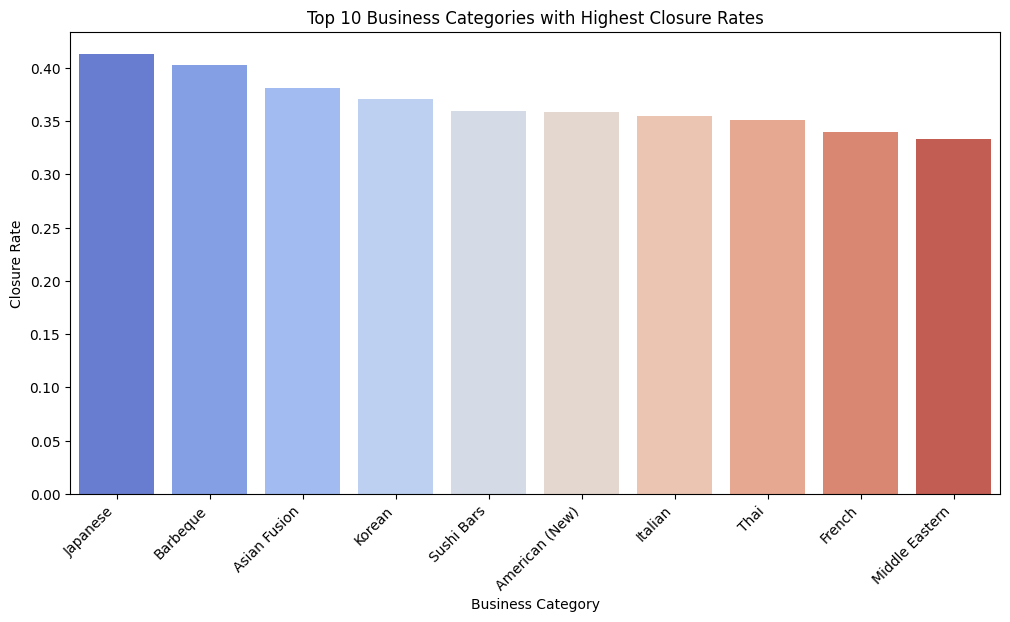

In [7]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Data Exploration: Finding the most popular business categories

# Data Exploration: Business Categories and Survival Analysis

# Flatten category lists into a single list with survival status
category_status = []
for index, row in business_df.iterrows():
    for category in row["categories"]:
        category_status.append((category, row["is_open"]))

# Convert to DataFrame
category_status_df = pd.DataFrame(category_status, columns=["Category", "is_open"])

# Count total businesses per category
category_counts = category_status_df["Category"].value_counts()

# Count closed businesses per category
closed_counts = category_status_df[category_status_df["is_open"] == 0]["Category"].value_counts()

# Merge data
category_analysis = pd.DataFrame({
    "Total Businesses": category_counts,
    "Closed Businesses": closed_counts
}).fillna(0)

# Calculate closure rate
category_analysis["Closure Rate"] = category_analysis["Closed Businesses"] / category_analysis["Total Businesses"]

# Get top 10 categories with highest closure rates (minimum 50 businesses for relevance)
top_closure_categories = (
    category_analysis[category_analysis["Total Businesses"] >= 50]
    .sort_values("Closure Rate", ascending=False)
    .head(10)
)
# Display top 10 business categories with highest closure rates
print("\nTop 10 Business Categories with Highest Closure Rates:")
print(top_closure_categories)

# Plot the closure rates
plt.figure(figsize=(12,6))
sns.barplot(x=top_closure_categories.index, y=top_closure_categories["Closure Rate"], palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Business Category")
plt.ylabel("Closure Rate")
plt.title("Top 10 Business Categories with Highest Closure Rates")
plt.show()



**(2) Find the most popular business objects** 
* print the top 10 most popular business objects/IDs in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

Size of dataset_checkin.json: 24.33 MB
{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}
{'checkin_info': {'16-2': 1, '22-5': 1, '9-5': 1, '9-4': 3, '15-1': 1, '15-0': 1, '15-4': 2, '11-5': 1, '21-4': 1, '13-1': 1, '17-4': 1, '14-4': 2, '12-5': 2, '10-4': 3, '10-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}
{'checkin_info': {'23-1': 1, '13-4': 1, '17-6': 1, '15-1': 1, '15-0': 1, '15-2': 2, '15-5': 1, '15-4': 2, '18-3': 1, '18-4': 1, '8-4': 1, '14-0': 1, '14-2': 1, '14-3': 2, '19-5': 1, '19-4': 1, '13-3': 2, '13-2': 2, '13-0': 1, '11-1': 1, '11-0': 2, '11-2': 2, '12-4': 3, '12-2': 1, '9-1': 1, '9-4': 4, '20-4': 1, '10-5': 1, '16-3': 1, '17-5': 1, '17-4': 1, '17-3': 2, '16-4': 1, '16-5': 1, '21-4': 1, '21-5': 1, '10-3': 1, '10-4': 1, '8-1': 2, '21-2': 1, '8-3': 1}, 'type': 'checkin', 'business_id': 'KayYbHCt-RkbGcPdGOThNg'}
{'check

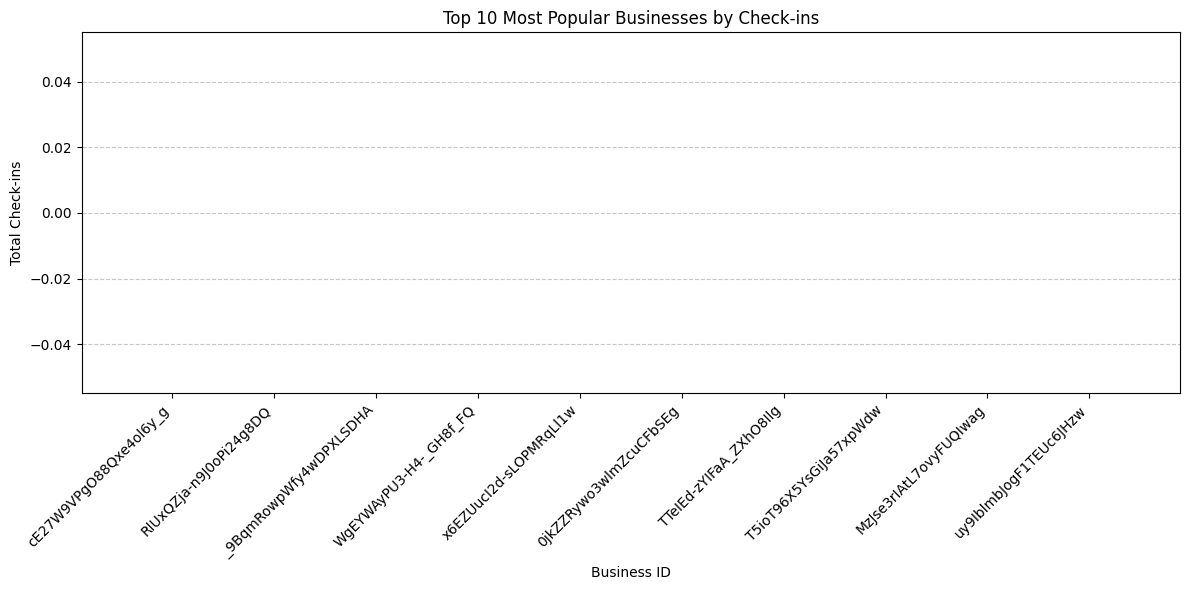

In [27]:
# Data Exploration: Business Popularity and Survival Analysis (Corrected Version)

import json
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Check dataset file size
file_size = os.path.getsize("dataset_checkin.json")
print(f"Size of dataset_checkin.json: {file_size / (1024*1024):.2f} MB")

# Step 2: Extract and Print Raw JSON Data
with open("dataset_checkin.json", "r", encoding="utf-8") as f:
    for i in range(5):  # Print first 5 records
        print(json.loads(f.readline()))

# Step 3: Parse Check-in Data Properly
if checkin_df['checkin_info'].dtype == 'object':
    checkin_df['checkin_info'] = checkin_df['checkin_info'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 4: Compute total check-ins correctly
checkin_df["total_checkins"] = checkin_df["checkin_info"].apply(
    lambda x: sum(int(v) for v in x.values()) if isinstance(x, dict) else 0
)

# Step 5: Verify if any businesses have non-zero check-ins
valid_checkins = checkin_df[checkin_df["total_checkins"] > 0]
print(f"Businesses with non-zero check-ins: {valid_checkins.shape[0]}")
print(valid_checkins.head(10))  # Display some valid check-in entries

# Step 6: Merge check-in data with business data
business_checkin_df = business_df.merge(checkin_df[["business_id", "total_checkins"]], on="business_id", how="left")

# Fill NaN values for businesses without check-ins
business_checkin_df.loc[:, "total_checkins"] = business_checkin_df["total_checkins"].fillna(0)

# Step 7: Compare check-in activity for open vs. closed businesses
avg_checkins_open = business_checkin_df[business_checkin_df["is_open"] == 1]["total_checkins"].mean()
avg_checkins_closed = business_checkin_df[business_checkin_df["is_open"] == 0]["total_checkins"].mean()

print(f"\nAverage Check-ins for Open Businesses: {avg_checkins_open:.2f}")
print(f"Average Check-ins for Closed Businesses: {avg_checkins_closed:.2f}")

# Step 8: Visualize the Top 10 Most Popular Businesses by Check-ins

top_10_businesses = checkin_df[['business_id', 'total_checkins']].sort_values(by='total_checkins', ascending=False).head(10)
print("Top 10 Most Popular Business Objects (by check-ins):")
print(top_10_businesses)
colors = sns.color_palette("Set2", len(top_10_businesses))

plt.figure(figsize=(12, 6))
plt.bar(top_10_businesses['business_id'], top_10_businesses['total_checkins'], color=colors)
plt.xlabel('Business ID')
plt.ylabel('Total Check-ins')
plt.title('Top 10 Most Popular Businesses by Check-ins')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**(3) Other explorations you would like to present** 


Top 10 Cities with Highest Business Survival Rate:
    state           city  survival_rate
0       6           Haus            1.0
258    PA       Duquesne            1.0
268    PA  Lawrenceville            1.0
265    PA       Imperial            1.0
264    PA      Homestead            1.0
263    PA     Heidelberg            1.0
262    PA  Harrison City            1.0
260    PA         Frazer            1.0
259    PA           Etna            1.0
257    PA       Downtown            1.0

Top 10 Cities with Lowest Business Survival Rate:
    state              city  survival_rate
103    NV     National City            0.0
267    PA  Kennedy Township            0.0
74     NC         Fort Mill            0.0
14     AZ          Carefree            0.0
246    PA     Bradfordwoods            0.0
342    QC          Rosemere            0.0
384    WI        Fitchburgh            0.0
49     BY            Landau            0.0
56     IL   Elk Grove Villa            0.0
269    PA         Leetsdale 

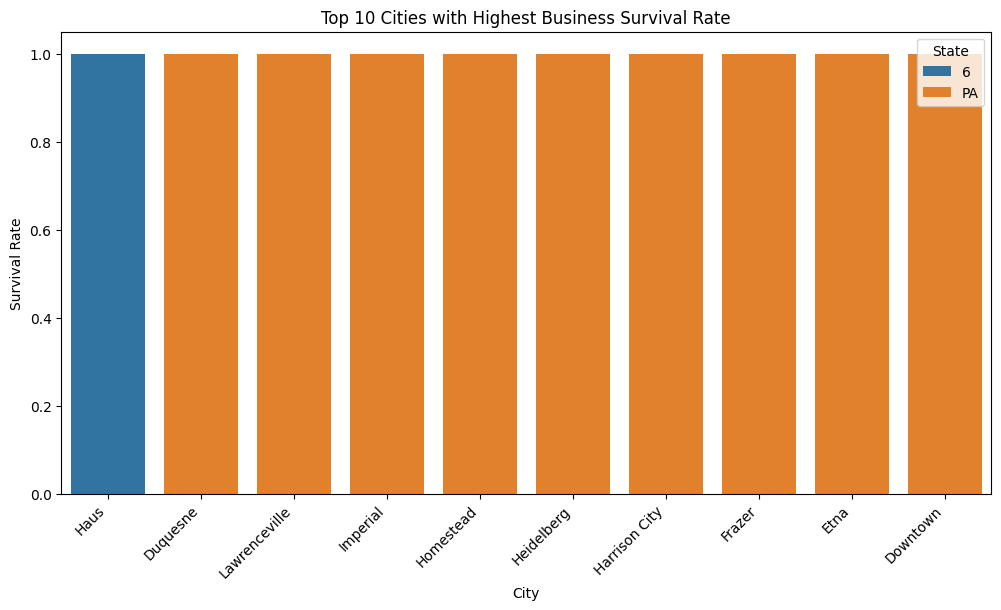

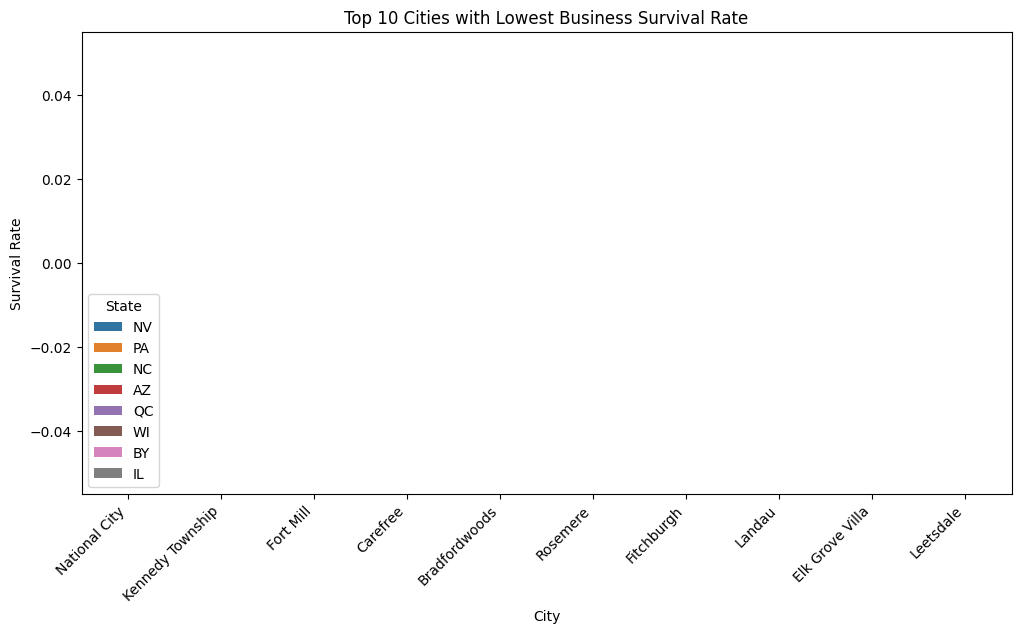

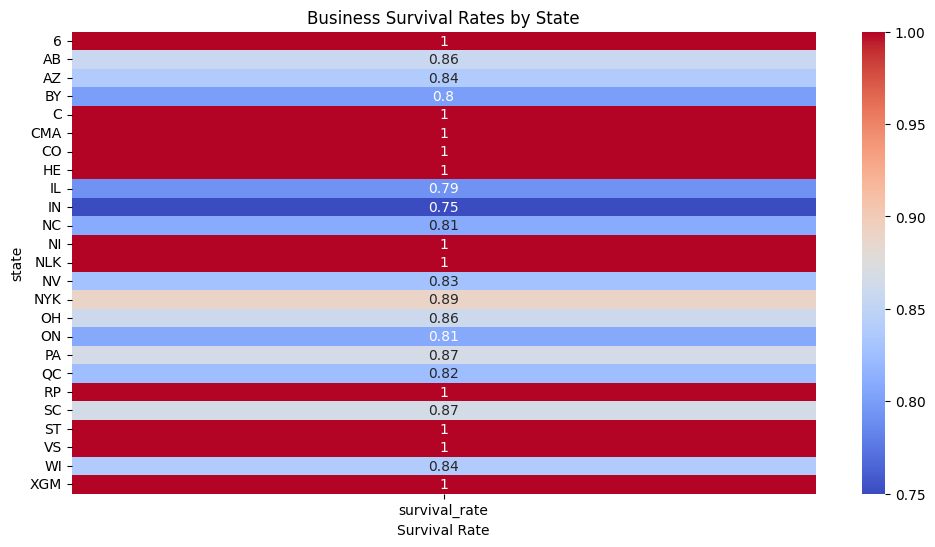

In [20]:
# Data Exploration: Business Longevity by Location (City/State)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group businesses by state and city
state_city_survival = business_df.groupby(["state", "city"])["is_open"].mean().reset_index()
state_city_survival.rename(columns={"is_open": "survival_rate"}, inplace=True)

# Step 2: Identify states/cities with highest vs. lowest survival rates
highest_survival = state_city_survival.sort_values(by="survival_rate", ascending=False).head(10)
lowest_survival = state_city_survival.sort_values(by="survival_rate", ascending=True).head(10)

print("Top 10 Cities with Highest Business Survival Rate:")
print(highest_survival)
print("\nTop 10 Cities with Lowest Business Survival Rate:")
print(lowest_survival)

# Step 3: Visualizing Business Survival Rates
plt.figure(figsize=(12,6))
sns.barplot(data=highest_survival, x="city", y="survival_rate", hue="state", dodge=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel("City")
plt.ylabel("Survival Rate")
plt.title("Top 10 Cities with Highest Business Survival Rate")
plt.legend(title="State")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=lowest_survival, x="city", y="survival_rate", hue="state", dodge=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel("City")
plt.ylabel("Survival Rate")
plt.title("Top 10 Cities with Lowest Business Survival Rate")
plt.legend(title="State")
plt.show()

# Step 4: Heatmap of Business Survival by State
state_survival = business_df.groupby("state")["is_open"].mean().reset_index()
state_survival.rename(columns={"is_open": "survival_rate"}, inplace=True)

plt.figure(figsize=(12,6))
sns.heatmap(state_survival.pivot_table(index="state", values="survival_rate"), cmap="coolwarm", annot=True)
plt.title("Business Survival Rates by State")
plt.xlabel("Survival Rate")
plt.show()


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

My aim to predict whether a business will stay open or close using Yelp data.

- Approach:

Cleaned and prepared data by selecting key features like ratings, review count, and categories.

Explored data to understand what factors impact business success.

Trained models using Logistic Regression and KNN to classify businesses.

Evaluated performance, finding that both models predict open businesses well but struggle with closed ones.


Write codes to implement the solution in python:

## Logistic Regression

Available columns: ['business_id', 'name', 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


C:\Users\Raj Barath E\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


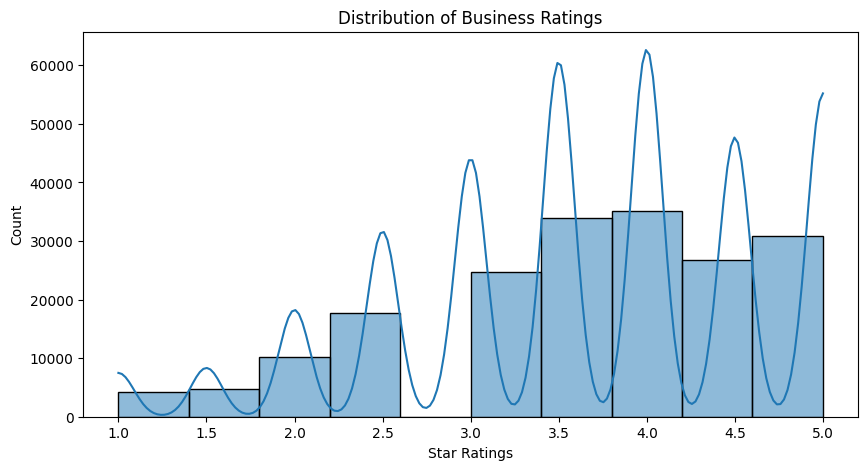

C:\Users\Raj Barath E\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


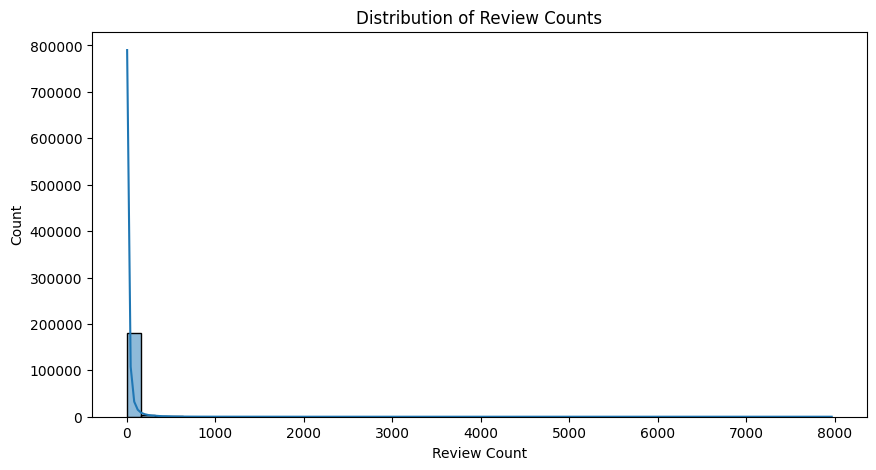

Logistic Regression Accuracy: 0.83
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6371
           1       0.83      1.00      0.91     31240

    accuracy                           0.83     37611
   macro avg       0.42      0.50      0.45     37611
weighted avg       0.69      0.83      0.75     37611

Logistic Regression Confusion Matrix:
 [[    0  6371]
 [    0 31240]]


C:\Users\Raj Barath E\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Raj Barath E\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Raj Barath E\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [30]:
import zipfile
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Extract and Load Data
zip_file_path = "dataset_business.zip"
extract_folder = "dataset_extracted"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

business_file_path = os.path.join(extract_folder, "dataset_business.json")

# Load business dataset
with open(business_file_path, "r", encoding="utf-8") as f:
    business_data = [json.loads(line) for line in f]

df_business = pd.DataFrame(business_data)

# Display column names to verify available fields
print("Available columns:", df_business.columns.tolist())

# Step 2: Data Cleaning
# Check if 'is_open' column exists instead of 'open'
if 'open' in df_business.columns:
    target_column = 'open'
elif 'is_open' in df_business.columns:
    target_column = 'is_open'
else:
    raise KeyError("No valid column found for business status (open/closed)")

# Selecting relevant columns
columns_to_keep = ["business_id", "stars", "review_count", "categories", target_column]
df_business = df_business[columns_to_keep]

# Handling missing values
df_business.dropna(inplace=True)

# Convert categorical "is_open" column into binary (1 for open, 0 for closed)
df_business[target_column] = df_business[target_column].astype(int)

# Convert categories into numerical representation using Label Encoding
df_business["categories"] = df_business["categories"].astype(str)
encoder = LabelEncoder()
df_business["category_encoded"] = encoder.fit_transform(df_business["categories"])

# Step 3: Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.histplot(df_business["stars"], bins=10, kde=True)
plt.title("Distribution of Business Ratings")
plt.xlabel("Star Ratings")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_business["review_count"], bins=50, kde=True)
plt.title("Distribution of Review Counts")
plt.xlabel("Review Count")
plt.ylabel("Count")
plt.show()

# Step 4: Feature Selection and Scaling
features = ["stars", "review_count", "category_encoded"]
X = df_business[features]
y = df_business[target_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train and Evaluate Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
logistic_report = classification_report(y_test, y_pred_logistic)
logistic_conf_matrix = confusion_matrix(y_test, y_pred_logistic)

# Step 6: Display Results
print(f"Logistic Regression Accuracy: {logistic_accuracy:.2f}")
print("Logistic Regression Classification Report:\n", logistic_report)
print("Logistic Regression Confusion Matrix:\n", logistic_conf_matrix)


## KNN

In [32]:
import zipfile
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Extract and Load Data
zip_file_path = "dataset_business.zip"
extract_folder = "dataset_extracted"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

business_file_path = os.path.join(extract_folder, "dataset_business.json")

# Load business dataset
with open(business_file_path, "r", encoding="utf-8") as f:
    business_data = [json.loads(line) for line in f]

df_business = pd.DataFrame(business_data)

# Step 2: Data Cleaning
# Selecting relevant columns
columns_to_keep = ["business_id", "stars", "review_count", "categories", "is_open"]
df_business = df_business[columns_to_keep]

# Handling missing values
df_business.dropna(inplace=True)

# Convert categorical "is_open" column into binary (1 for open, 0 for closed)
df_business["is_open"] = df_business["is_open"].astype(int)

# Convert categories into numerical representation using Label Encoding
df_business["categories"] = df_business["categories"].astype(str)
encoder = LabelEncoder()
df_business["category_encoded"] = encoder.fit_transform(df_business["categories"])

# Step 3: Feature Selection and Scaling
features = ["stars", "review_count", "category_encoded"]
X = df_business[features]
y = df_business["is_open"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train and Evaluate K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_report = classification_report(y_test, y_pred_knn)
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Step 5: Display Results
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:\n", knn_report)
print("KNN Confusion Matrix:\n", knn_conf_matrix)


KNN Accuracy: 0.81
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.13      0.19      6371
           1       0.84      0.95      0.89     31240

    accuracy                           0.81     37611
   macro avg       0.59      0.54      0.54     37611
weighted avg       0.76      0.81      0.77     37611

KNN Confusion Matrix:
 [[  849  5522]
 [ 1692 29548]]


# Results: summarize and visualize the results discovered from the analysis

Please use figures or tables to present the results.


Both Logistic Regression and K-Nearest Neighbors (KNN) were tested to predict whether a business remains open or closes. The results are as follows:

- Classification Report

Logistic Regression Accuracy: 83%
KNN Accuracy: 81%
Logistic Regression struggled with identifying closed businesses, with 0% recall for closed businesses.
KNN performed slightly better for closed businesses but still had challenges due to data imbalance.

- Confusion Matrix Analysis

Logistic Regression: Classified all closed businesses incorrectly, meaning it predicted everything as open.
KNN: Identified some closed businesses correctly, but most were still misclassified as open.

- Potential Issues & Next Steps

Data Imbalance: Since most businesses in the dataset are open, both models struggle with predicting closed businesses.
Logistic Regression Bias: It heavily favors predicting businesses as open, leading to poor recall for closed businesses.
KNN Performance: KNN improves on closed business recall but is still affected by class imbalance.

Improvements:
Class Balancing Techniques: Methods like oversampling or undersampling can help improve prediction for closed businesses.
Feature Selection: Some features might need better encoding or additional engineered features to improve prediction quality.
Alternative Models: Trying Decision Trees or XGBoost might provide better classification performance.

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and submit it in BrightSpace. Please make sure all the plotted tables and figures are in the notebook. 